# Introduction
In this project, my goal is to create a CNN model to identify genders between male and female. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

The objective of this study is to understand and implement different CNN models to correctly identify genders from a dataset of tens of thousands of celebrity images. In the end, we will compare the result between different CNN models.  

## Description of dataset
In this dataset, you are provided with a large number of small celebrities faces images to classify. Files are named with an image id. A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. The content:

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

## Obtaining the dataset
You can download the dataset from Kaggle at following link https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
<br>
There are 5 files: 
- img_align_celeba.zip: All the face images, cropped and aligned
- list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

The size total about 1.3Gb.

## Libraries Import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input,Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Add
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Exploratory Data Analysis (EDA)

In [2]:
# Path to the folder containing image files
photo_folder = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

# List all image file paths in the folder
photo_paths = tf.data.Dataset.list_files(os.path.join(photo_folder, '*.jpg'))
num_files = len(list(photo_paths))
print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 202599


There are 202599 celebrity faces images in the dataset. Now let's read in the attributes files to see which attributes are there.

In [3]:
attr_df = pd.read_csv('/kaggle/input/celeba-dataset/list_attr_celeba.csv')

In [4]:
attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

There are 40 attributes but for the purpose of this project, we will only care about two attributes which are 'image_id' and 'male'.

In [5]:
attr_df[['image_id','Male']]

image_id  Male
0       000001.jpg    -1
1       000002.jpg    -1
2       000003.jpg     1
3       000004.jpg    -1
4       000005.jpg    -1
...            ...   ...
202594  202595.jpg    -1
202595  202596.jpg     1
202596  202597.jpg     1
202597  202598.jpg    -1
202598  202599.jpg    -1

[202599 rows x 2 columns]

As I can see 'Male' attribute contains labels indicating whether a male or not a male (which is a female). Here 1 stands for Male and -1 stands for Not Male which is Female.

In [6]:
partition_df = pd.read_csv('/kaggle/input/celeba-dataset/list_eval_partition.csv')

In [7]:
partition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   image_id   202599 non-null  object
 1   partition  202599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [8]:
partition_df['partition'].unique()

array([0, 1, 2])

The partition dataset contains the partition indices for train set, validation set and test set. The value of 'parition' columns are 0,1,2 so I guess partition 0 stands for train set, partition 1 stands for validation set, partition 2 stands for test set.

In [9]:
partition_df[partition_df['partition']==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162770 entries, 0 to 162769
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   image_id   162770 non-null  object
 1   partition  162770 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


In [10]:
partition_df[partition_df['partition']==0]

image_id  partition
0       000001.jpg          0
1       000002.jpg          0
2       000003.jpg          0
3       000004.jpg          0
4       000005.jpg          0
...            ...        ...
162765  162766.jpg          0
162766  162767.jpg          0
162767  162768.jpg          0
162768  162769.jpg          0
162769  162770.jpg          0

[162770 rows x 2 columns]

As I can see, partition 0 is from image 1 to image 162770. So there are 162770 face images for training.

In [11]:
partition_df[partition_df['partition']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19867 entries, 162770 to 182636
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   19867 non-null  object
 1   partition  19867 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 465.6+ KB


In [12]:
partition_df[partition_df['partition']==1]

image_id  partition
162770  162771.jpg          1
162771  162772.jpg          1
162772  162773.jpg          1
162773  162774.jpg          1
162774  162775.jpg          1
...            ...        ...
182632  182633.jpg          1
182633  182634.jpg          1
182634  182635.jpg          1
182635  182636.jpg          1
182636  182637.jpg          1

[19867 rows x 2 columns]

As I can see, partition 1 is from image 162771 to image 182637. So there are 19867 face images for validation.

In [13]:
partition_df[partition_df['partition']==2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19962 entries, 182637 to 202598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image_id   19962 non-null  object
 1   partition  19962 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 467.9+ KB


Finally, the rest is for test set. So there are 19962 face images for testing.

In [14]:
df = attr_df[['image_id','Male']]
img_path = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
file_list = [df['image_id'][i] for i in range(df.shape[0])]
file_path_list = [img_path + i for i in file_list]
df['path'] = file_path_list

/tmp/ipykernel_201/1536146686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path'] = file_path_list


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  202599 non-null  object
 1   Male      202599 non-null  int64 
 2   path      202599 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


I needed a new dataframe which contains only image_id and Male attributes from the attributes dataset. In the new dataframe, I also created a column 'path' whose value is the exact path of each image in the photo folder.

In [16]:
df['Male'] = df['Male'].replace(-1, 0)
labels = df['Male'].values
ds_files_labels = tf.data.Dataset.from_tensor_slices((file_path_list,labels))

/tmp/ipykernel_201/3254233984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Male'] = df['Male'].replace(-1, 0)


<Axes: xlabel='Male', ylabel='count'>

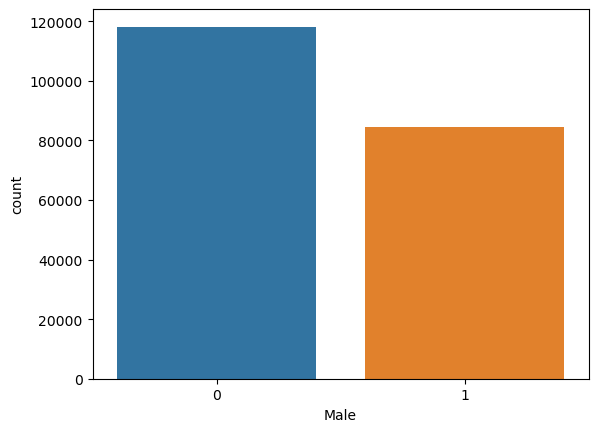

In [17]:
sns.countplot(x = 'Male', data= df)

In [18]:
df['Male'].value_counts()

0    118165
1     84434
Name: Male, dtype: int64

I replaced the -1 value with 0 for Male column. And do a barplot with value counts to see the number for each gender. Here 0 stands for Not Male or Female. And 1 stands for Male. I can see the number of females face images is roughly 58% while number of males face images is about 42% of the whole dataset. 

In [19]:
# Get the dimensions (width and height)
for item in ds_files_labels.take(1): 
    img = Image.open(item[0].numpy())
    width, height = img.size

    print(f"Image dimensions: Width = {width}, Height = {height}")

Image dimensions: Width = 178, Height = 218


So the input size or the image size is (178,218). Now let's take a look at some images from the dataset. Please note 0 stands for False and 1 stand for True. So 'Male: 0' means Female, and 'Male: 1' means Male. 

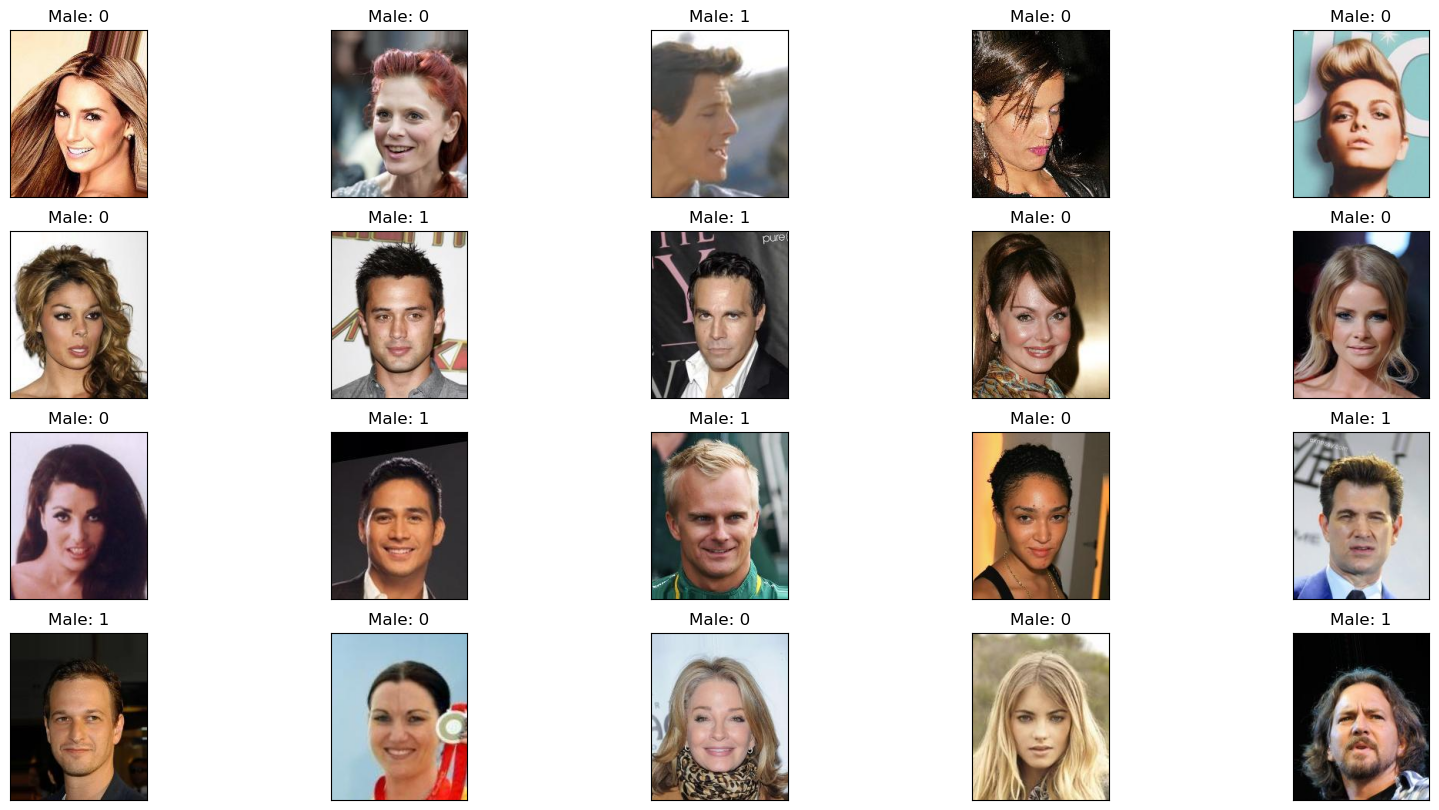

In [20]:
fig = plt.figure(figsize=(20,10))
i = 1;

for item in ds_files_labels.take(20):
    ax = fig.add_subplot(4,5, i, xticks=[], yticks=[])
    img = Image.open(item[0].numpy())
    plt.imshow(img)
    male = item[1].numpy()
    ax.set_title(f'Male: {male}')
    i+=1
plt.show()

## Data Preparation

### Image transformation and data augmentation

Data augmentation summarizes a broad set of techniques for dealing with cases where the training data is limited. For instances, certain data augmentation techniques allow us to modify or even artificially synthesize more data and thereby boost the performance of a machine or deep learning model by reducing overfitting. There are a set of transformations uniquely applicable to image data, such as cropping parts of an image, flipping, changing the contrast, brightness, and staturation. Let's see some of these transformations by the examples below:

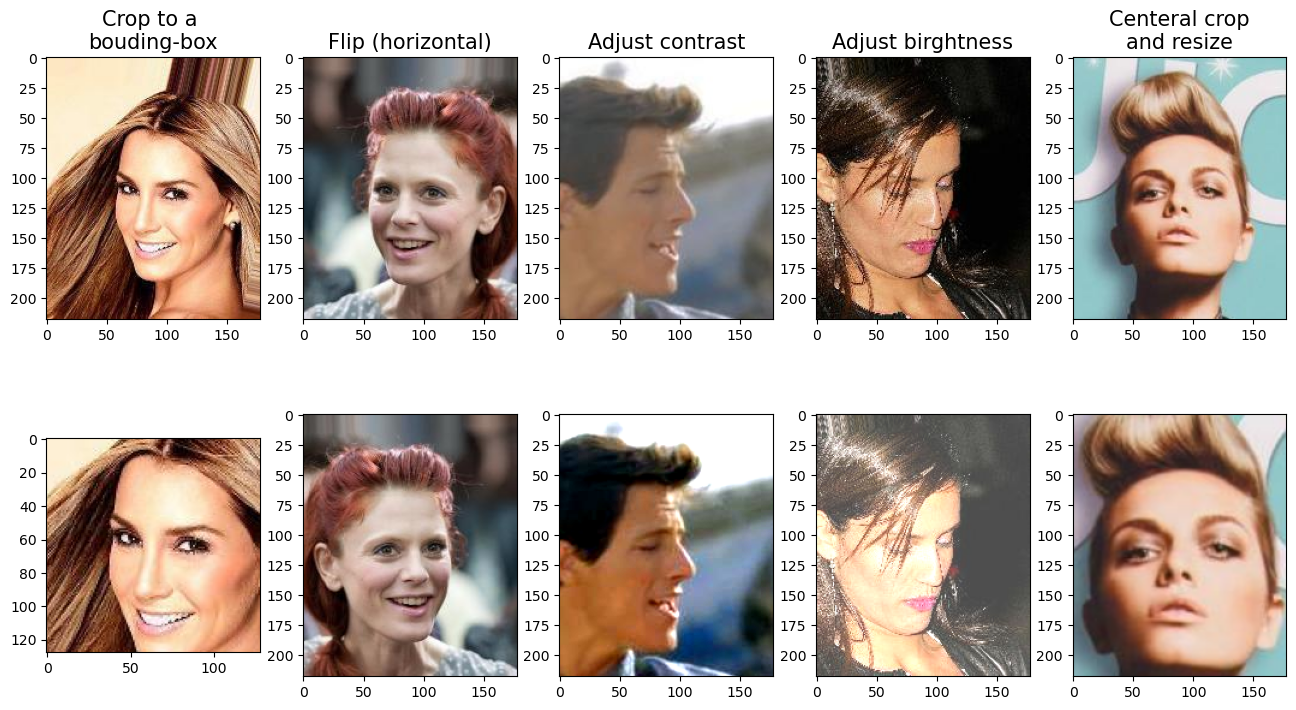

In [21]:
examples = []
for example in ds_files_labels.take(5):
    examples.append(example[0])

fig = plt.figure(figsize=(16,8.5))
ax = fig.add_subplot(2,5,1)
ax.set_title('Crop to a \nbouding-box', size =15)
img = Image.open(examples[0].numpy())
ax.imshow(img)
ax = fig.add_subplot(2,5,6)
img_cropped = tf.image.crop_to_bounding_box(img,50,20,128,128)
ax.imshow(img_cropped)

ax = fig.add_subplot(2,5,2)
ax.set_title('Flip (horizontal)', size =15)
img = Image.open(examples[1].numpy())
ax.imshow(img)
ax = fig.add_subplot(2,5,7)
img_flipped = tf.image.flip_left_right(img)
ax.imshow(img_flipped)

ax = fig.add_subplot(2,5,3)
ax.set_title('Adjust contrast', size =15)
img = Image.open(examples[2].numpy())
ax.imshow(img)
ax = fig.add_subplot(2,5,8)
img_adj_contrast = tf.image.adjust_contrast(img,contrast_factor =2)
ax.imshow(img_adj_contrast)

ax = fig.add_subplot(2,5,4)
ax.set_title('Adjust birghtness', size =15)
img = Image.open(examples[3].numpy())
ax.imshow(img)
ax = fig.add_subplot(2,5,9)
img_adj_brightness = tf.image.adjust_brightness(img,delta = 0.3)
ax.imshow(img_adj_brightness)

ax = fig.add_subplot(2,5,5)
ax.set_title('Centeral crop\nand resize', size =15)
img = Image.open(examples[4].numpy())
ax.imshow(img)
ax = fig.add_subplot(2,5,10)
img_center_crop = tf.image.central_crop(img,0.7)
img_resized = tf.image.resize(img_center_crop, size =(218,178))
ax.imshow(img_resized.numpy().astype('uint8'))

plt.show()

Now I will need to apply some of these transformations to my training images. But first, let's create the dataset for training, validation, and testing.

In [22]:
image_size = (178, 218)
batch_size = 32
# Convert numeric labels to strings

df['Male'] = df['Male'].astype(str)

/tmp/ipykernel_201/4141878257.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Male'] = df['Male'].astype(str)


In [23]:
# Define the sizes for train, validation, and test sets
train_size = 162770
val_size = 19867
test_size = 19962

# Split the dataframe using index slicing
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

<Axes: xlabel='Male', ylabel='count'>

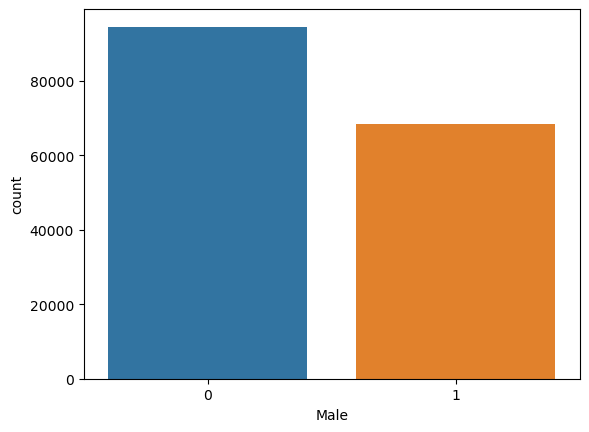

In [24]:
sns.countplot(x = 'Male', data= train_df)

In [25]:
train_df['Male'].value_counts()

0    94509
1    68261
Name: Male, dtype: int64

I created train dataframe which contains all the images for training, validation dataframe which contains all the images for validating, and finally the test datafram which contrains all the images for testing. In the train dataframe, I plotted the bar counts for gender (Male or Not Male). I can see the number of female is 58% while the number of male is 42% in the train dataframe. So I do not have a balanced data here. But the unbalance is not that much of a deal.

In [26]:
class TrainImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def next(self):
        batch_x, batch_y = super().next()
        
        # Apply your custom image modification operations here
        batch_x_processed = tf.image.adjust_brightness(
            tf.image.random_flip_left_right(
                tf.image.resize(
                    tf.image.random_crop(batch_x, size=(178, 178, 3)),
                    size=(64,64,3)
                ),
                delta=0.3
            )
        )
        
        return batch_x_processed, batch_y

In [27]:
class ValImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def next(self):
        batch_x, batch_y = super().next()
        
        # Apply your custom image modification operations here
        batch_x_processed = tf.tf.image.resize(
        tf.image.crop_to_bounding_box(img, offset_height=20, offset_width=0, target_height=178, target_width=178),
        size=(64, 64,3))
        
        return batch_x_processed, batch_y

In order to apply the images transformation, I had to create two DataGenerator classes that inherited from ImageDataGenerator classes, each for training and validating. In the TrainImageDataGenerator, I first randomly cropped the processed image, then I resize each processed image to size (64,64), then I flipped the image from left to right and adjusted its brightness. Meanwhile in the ValImageDataGenerator, I just cropped each image to a bounding box (178,178) then resized it to (64,64). Now let's use the two DataGenerator classes to generate data flow from 3 dataframes: train, validation, and test.

In [28]:
# Define data generators for train, validation, and test sets
train_datagen = TrainImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=None
)

val_datagen = ValImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=None
)

test_datagen = ValImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=None
)

In [29]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='Male',
    target_size= (64,64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 162770 validated image filenames belonging to 2 classes.


In [30]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='Male',
    target_size=(64,64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 19867 validated image filenames belonging to 2 classes.


In [31]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='Male',
    target_size=(64,64),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 19962 validated image filenames belonging to 2 classes.


I have successfully created train_generator which contains all the transformed images with their lables for training, val_generator for validation and test_generator for testing. Now its' time to build the models.

# Models Training

## Simple CNN Model
Since the image is 64*64*3, which is not a great complexed training object, I decided to implement a simple CNN architecture. Here I made a simple model that has 4 convolution layers with increasing number of feature maps (32,64,128,256). For the first two convolution layers, I used MaxPooling layer to reduce the number of deep layers. Since I do not have a very balanced dataset, it might be useful to normalize or regularize our data by Dropout. Therefore after each of these two layers I would add Dropout with probability of 0.5. Then I need to flatten into a 512 Dense layers before output layer with sigmoid activation for binary output.

In [32]:
def simple_cnn(input_size=(64, 64, 3)):
    inputs = Input(input_size)
    # Convolutional layers
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    dropout1 = Dropout(0.5)(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(dropout1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    dropout2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Flatten and fully connected layers
    flatten = Flatten()(pool4)
    dense1 = Dense(512, activation='relu')(flatten)
    dense2 = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=inputs, outputs=dense2)
    return model

In [33]:
simple_cnn_model = simple_cnn()

In [34]:
# Compile the model
simple_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simple_cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                         

This is the summary of the simple cnn model that I implemented. Now I would need to define early stopping to stop training when the validation loss stops improving. This may reduce overfitting and training time. I also declared a check point call back for my simple cnn model so later I can use it.

In [35]:
# Define the EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [36]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_simple_cnn_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

It's time to train my simple cnn model. I put the number of max epoch = 20 with early stopping and checkpoint callback. 

In [37]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 20  
history = simple_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/20


2023-08-16 16:12:35.972810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5087/5087 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9092
Epoch 1: val_loss improved from inf to 0.12609, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 262s 51ms/step - loss: 0.2164 - accuracy: 0.9092 - val_loss: 0.1261 - val_accuracy: 0.9528
Epoch 2/20
5087/5087 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9423
Epoch 2: val_loss improved from 0.12609 to 0.08926, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 311s 61ms/step - loss: 0.1490 - accuracy: 0.9423 - val_loss: 0.0893 - val_accuracy: 0.9671
Epoch 3/20
5087/5087 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9474
Epoch 3: val_loss improved from 0.08926 to 0.08824, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 235s 46ms/step - loss: 0.1362 - accuracy: 0.9474 - val_loss: 0.0882 - val_accuracy: 0.9674
Epoch 4/20
5087/5087 [============

Training is completed after 16 epochs. Now let's draw the plots for losses and accuracies to visualize how model learnt.

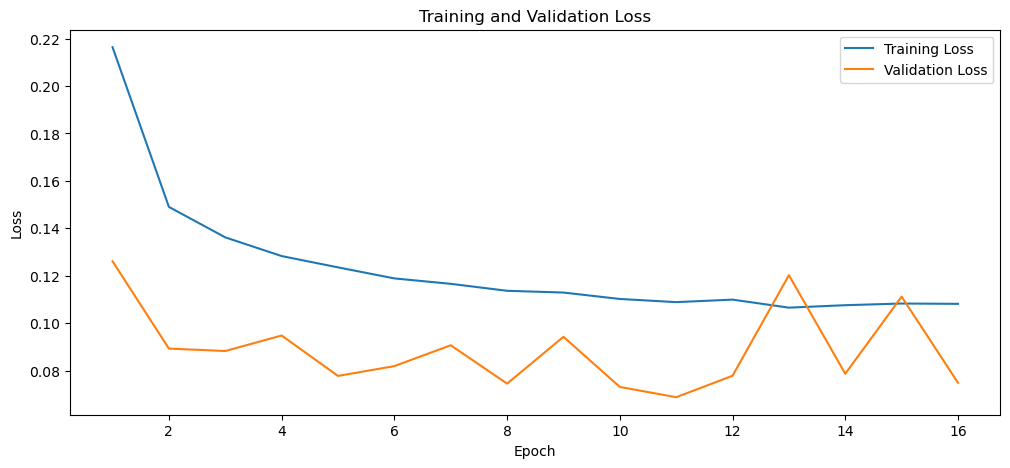

In [38]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(12,5))

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

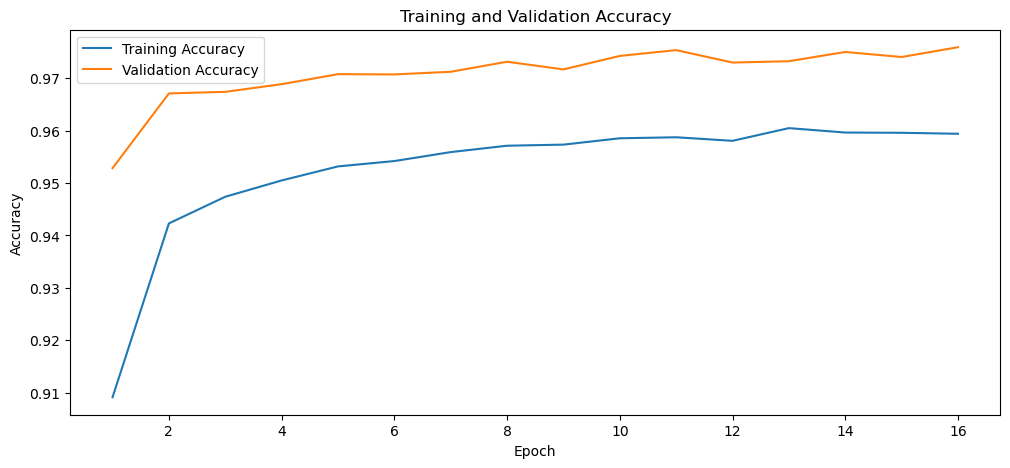

In [39]:
# Extract the training and validation accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(12,5))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [40]:
best_simple_cnn_model = tf.keras.models.load_model('best_simple_cnn_model.h5')

valid_loss, valid_accuracy = best_simple_cnn_model.evaluate(val_generator)
print("Validation Loss For Best CCM Model:", valid_loss)
print("Valid Accuracy For Best CCM Model:", valid_accuracy)

621/621 [==============================] - 27s 43ms/step - loss: 0.0688 - accuracy: 0.9753
Validation Loss For Best CCM Model: 0.06875097751617432
Valid Accuracy For Best CCM Model: 0.975335955619812


Plots showed that validation loss and accuracy best achieved at epoch = 11. The validation loss is 0.0687 and validation accuracy is 97.53%. Let's do some parameters tuning.

### Hyperparameters Tuning
I will unfreeze some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I will fit another 5 epochs from the best model for fine tuning.

In [41]:
# Unfreeze some layers for fine-tuning
for layer in best_simple_cnn_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_simple_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_simple_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5


2023-08-16 17:22:13.157035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5087/5087 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9660
Epoch 1: val_loss improved from 0.06875 to 0.06470, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 254s 49ms/step - loss: 0.0894 - accuracy: 0.9660 - val_loss: 0.0647 - val_accuracy: 0.9771
Epoch 2/5
5087/5087 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9675
Epoch 2: val_loss improved from 0.06470 to 0.06240, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 235s 46ms/step - loss: 0.0855 - accuracy: 0.9675 - val_loss: 0.0624 - val_accuracy: 0.9776
Epoch 3/5
5086/5087 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9678
Epoch 3: val_loss improved from 0.06240 to 0.06095, saving model to best_simple_cnn_model.h5
5087/5087 [==============================] - 233s 46ms/step - loss: 0.0835 - accuracy: 0.9678 - val_loss: 0.0609 - val_accuracy: 0.9781
Epoch 4/5
5086/5087 [===========

In [42]:
best_simple_cnn_model = tf.keras.models.load_model('best_simple_cnn_model.h5')
valid_loss_list = []
valid_accuracy_list = []
valid_loss, valid_accuracy = best_simple_cnn_model.evaluate(val_generator)
valid_loss_list.append(valid_loss)
valid_accuracy_list.append(valid_accuracy)
print("Validation Loss After Tuning:", valid_loss)
print("Validation Accuracy After Tuning:", valid_accuracy)

621/621 [==============================] - 24s 39ms/step - loss: 0.0605 - accuracy: 0.9778
Validation Loss After Tuning: 0.06051654741168022
Validation Accuracy After Tuning: 0.9778023958206177


After tuning, I was able to achieve validation loss of 0.0605 and validation accurary of 97.78%

### Test Set Evaluation
After getting my best tuned model of simple cnn model, it's time to make a test prediction and evaluation.

In [43]:
test_loss_list = []
test_accuracy_list = []
test_loss, test_accuracy = best_simple_cnn_model.evaluate(test_generator)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)
print("Test Set Loss:", test_loss)
print("Test Set Accuracy:", test_accuracy)

624/624 [==============================] - 127s 204ms/step - loss: 0.0852 - accuracy: 0.9704
Test Set Loss: 0.08520500361919403
Test Set Accuracy: 0.9703937768936157


The accuracy of the test set is 97.04% which is very impressive. Now let's draw some images from the test set, show their predicted gender with its probability generated by my simple cnn model.

624/624 [==============================] - 26s 41ms/step


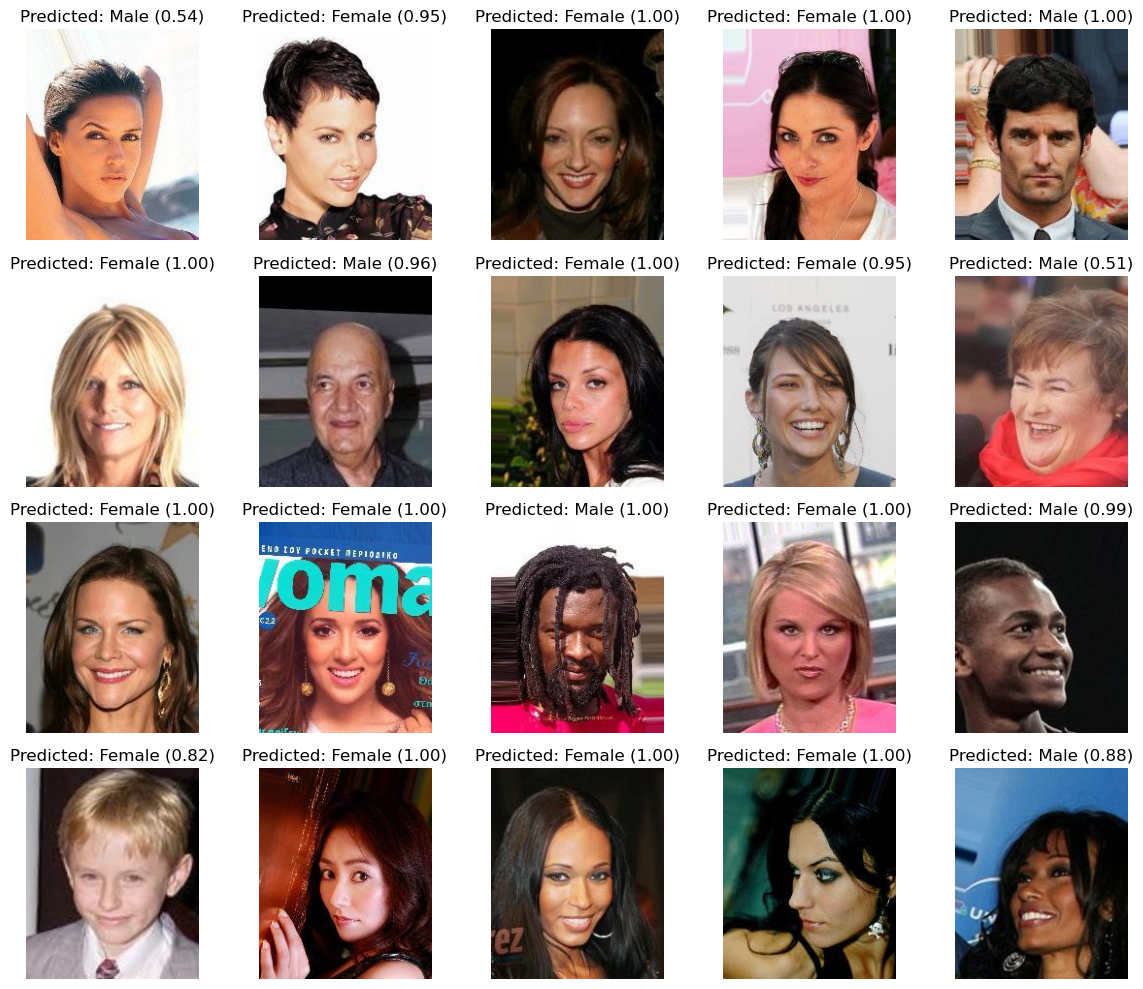

In [59]:
# Select 20 sample indices from the test set
sample_indices = np.random.choice(len(test_generator), size=20, replace=False)

# Use predict_generator to get predicted probabilities
test_predictions = best_simple_cnn_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels based on a threshold
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)

# Display sample images in a 5x4 grid
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    if i < len(sample_indices):
        index = sample_indices[i]
        image_path = test_generator.filepaths[index]
        image = Image.open(image_path)
        predicted_probability = test_predictions[index][0]
        predicted_label = binary_predictions[index][0]
        
        ax.imshow(image)
        ax.set_title(f'Predicted: Male ({predicted_probability:.2f})' if predicted_label == 1 else f'Predicted: Female ({1-predicted_probability:.2f})')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

I can see for female images that are predicted male by the model has very low probabilities. Because my threshold is 0.5, and probabilities greater than 0.5 are predicted male. However the wrong predictions have probabilities indicating male as 0.54 or 0.51 which are very close to be flipped in prediction. And the wrong prediction that predicted female instead of male, has high probability of 82%, but the image is of a kid celebrity's face. That would raise question if the model works well with adult faces but not with kid faces ? And the wrong prediction that predicted female instead of male, has high probability of 88%, but the image is of a black female celebrity's face. That would raise question if the model works well with caucasian faces but not with black people's faces ?

## Simple ResNet Model
Residual Network (ResNet) is a deep learning model used for computer vision applications. It is a Convolutional Neural Network (CNN) architecture designed to support hundreds or thousands of convolutional layers. Previous CNN architectures were not able to scale to a large number of layers, which resulted in limited performance. However, when adding more layers, researchers faced the “vanishing gradient” problem.

Neural networks are trained through a backpropagation process that relies on gradient descent, shifting down the loss function and finding the weights that minimize it. If there are too many layers, repeated multiplications will eventually reduce the gradient until it “disappears”, and performance saturates or deteriorates with each layer added.

ResNet provides an innovative solution to the vanishing gradient problem, known as “skip connections”. ResNet stacks multiple identity mappings (convolutional layers that do nothing at first), skips those layers, and reuses the activations of the previous layer. Skipping speeds up initial training by compressing the network into fewer layers. 

Here I just developed a simple version of ResNet instead of using transfer learning such as ResNet50.

In [44]:
def resnet_cnn(input_size=(64, 64, 3)):
    inputs = Input(input_size)
    
    # First convolutional block
    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    num_blocks = 3  # Number of residual blocks
    num_filters = 64
    for _ in range(num_blocks):
        shortcut = x
        
        # First convolutional layer
        x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        
        # Second convolutional layer
        x = Conv2D(num_filters, (3, 3), activation=None, padding='same')(x)
        x = BatchNormalization()(x)
        
        # Adjusting shortcut connection to match the number of filters
        shortcut = Conv2D(num_filters, (1, 1), activation=None, padding='same')(shortcut)
        
        # Residual connection
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        
        # Double the number of filters for the next block
        num_filters *= 2
    
    # Global average pooling and fully connected layers
    x = AveragePooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
resnet_model = resnet_cnn()

In [46]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 64)  0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 64)   36928       ['max_pooling2d_4[0][0]']        
                                                                                            

This is the summary of my simple ResNet model. Please note that even though my ResNet is a simple version, it is still considered a much more complexed than the other simple CNN model implemented above.

In [47]:
# Create a ModelCheckpoint callback to save the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_resnet_model.h5',
    monitor='val_loss',  
    mode='min',              
    save_best_only=True,     
    save_weights_only=False, 
    verbose=1
)

It's time to train my simple cnn model. I put the number of max epoch = 20 with early stopping and checkpoint callback. 

In [48]:
# Fit the model to the data using the generators and the EarlyStopping and ModelCheckpoint callbacks
epochs = 20  
history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/20
5087/5087 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9194
Epoch 1: val_loss improved from inf to 0.38642, saving model to best_resnet_model.h5
5087/5087 [==============================] - 384s 74ms/step - loss: 0.2097 - accuracy: 0.9194 - val_loss: 0.3864 - val_accuracy: 0.9160
Epoch 2/20
5086/5087 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9491
Epoch 2: val_loss did not improve from 0.38642
5087/5087 [==============================] - 250s 49ms/step - loss: 0.1310 - accuracy: 0.9491 - val_loss: 2.3027 - val_accuracy: 0.9634
Epoch 3/20
5086/5087 [============================>.] - ETA: 0s - loss: 0.1085 - accuracy: 0.9582
Epoch 3: val_loss did not improve from 0.38642
5087/5087 [==============================] - 247s 49ms/step - loss: 0.1085 - accuracy: 0.9582 - val_loss: 6.7740 - val_accuracy: 0.9628
Epoch 4/20
5087/5087 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9635
Epoch 4: val_loss did

Training is completed after 6 epochs. Let's draw the plots for losses and accuracies for better visualization of how the ResNet model learnt.

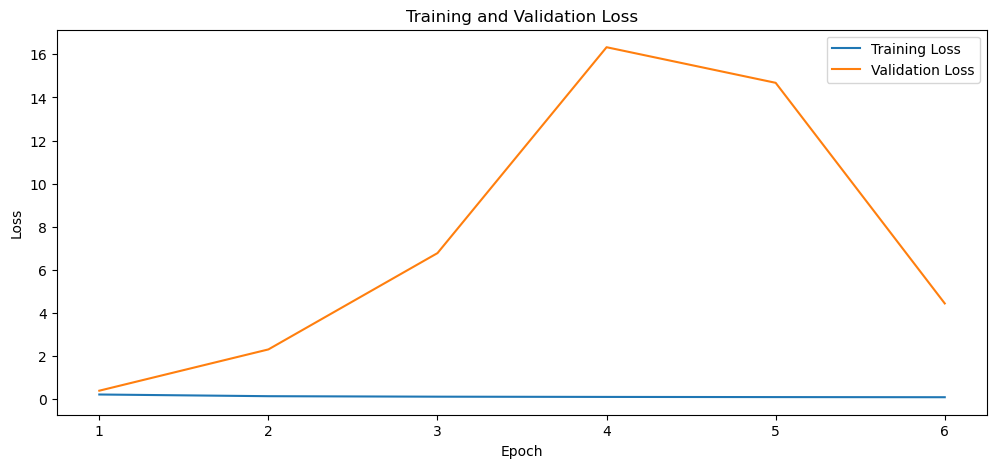

In [49]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(12,5))

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

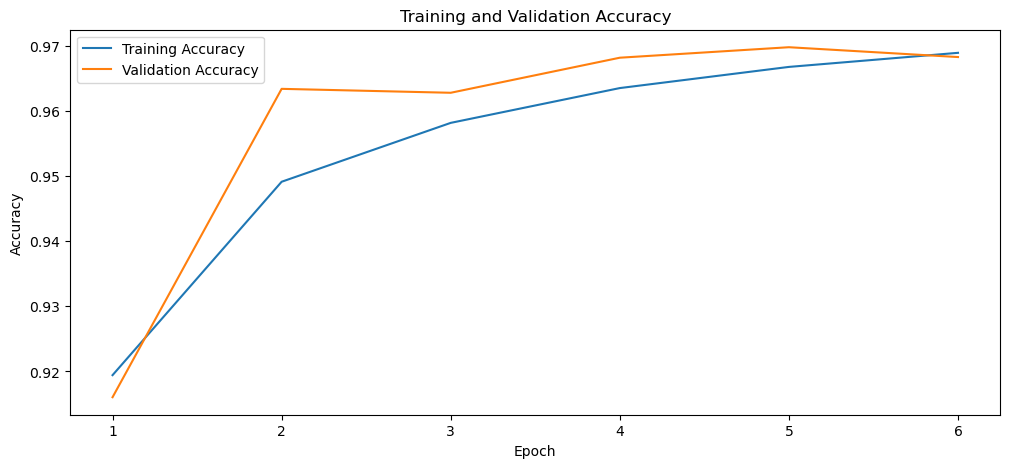

In [50]:
# Extract the training and validation accuracy from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create the plot
plt.figure(figsize=(12,5))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()

In [51]:
best_resnet_model = tf.keras.models.load_model('best_resnet_model.h5')

valid_loss, valid_accuracy = best_resnet_model.evaluate(val_generator)
print("Validation Loss For Best Resnet Model:", valid_loss)
print("Valid Accuracy For Best Resnet Model:", valid_accuracy)

621/621 [==============================] - 27s 43ms/step - loss: 0.3864 - accuracy: 0.9160
Validation Loss For Best Resnet Model: 0.3864193856716156
Valid Accuracy For Best Resnet Model: 0.9160416722297668


The validation loss and accuracy best achieved at epoch 1. The validation loss is about 0.3864 and validation accurarcy is 91.60%. Let's do some parameters tuning.

### Hyperparameters Tuning
I will unfreeze some layers for fine tuning, and I also adjusted the learning rate from 0.001 to 0.0001. Then I will fit another 5 epochs from the best model for fine tuning.

In [52]:
# Unfreeze some layers for fine-tuning
for layer in best_resnet_model.layers:
    layer.trainable = True

# Compile the best model again with a lower learning rate for fine-tuning
best_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the best model to the data again for fine-tuning
fine_tune_epochs = 5  
history_fine_tune = best_resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=[checkpoint_callback]
)

Epoch 1/5
5087/5087 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9579
Epoch 1: val_loss did not improve from 0.38642
5087/5087 [==============================] - 265s 51ms/step - loss: 0.1090 - accuracy: 0.9579 - val_loss: 0.5845 - val_accuracy: 0.9651
Epoch 2/5
5087/5087 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9646
Epoch 2: val_loss did not improve from 0.38642
5087/5087 [==============================] - 257s 51ms/step - loss: 0.0921 - accuracy: 0.9646 - val_loss: 0.9235 - val_accuracy: 0.9679
Epoch 3/5
5086/5087 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9694
Epoch 3: val_loss did not improve from 0.38642
5087/5087 [==============================] - 238s 47ms/step - loss: 0.0803 - accuracy: 0.9694 - val_loss: 1.1684 - val_accuracy: 0.9685
Epoch 4/5
5086/5087 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9741
Epoch 4: val_loss did not improve from 0.38642
5087/5087 [=====

In [53]:
best_resnet_model = tf.keras.models.load_model('best_resnet_model.h5')
valid_loss, valid_accuracy = best_resnet_model.evaluate(val_generator)
valid_loss_list.append(valid_loss)
valid_accuracy_list.append(valid_accuracy)
print("Validation Loss After Tuning:", valid_loss)
print("Validation Accuracy After Tuning:", valid_accuracy)

621/621 [==============================] - 25s 40ms/step - loss: 0.3864 - accuracy: 0.9160
Validation Loss After Tuning: 0.3864193856716156
Validation Accuracy After Tuning: 0.9160416722297668


It seems like tuning did not help the ResNet model to achieve better validation loss or accurarcy. It's time to make test prediction and evaluation.

### Test Set Evaluation
After getting my best tuned model of simple cnn model, it's time to make a test prediction and evaluation.

In [54]:
test_loss, test_accuracy = best_resnet_model.evaluate(test_generator)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)
print("Test Set Loss:", test_loss)
print("Test Set Accuracy:", test_accuracy)

624/624 [==============================] - 47s 75ms/step - loss: 0.3258 - accuracy: 0.8981
Test Set Loss: 0.3258262276649475
Test Set Accuracy: 0.8981063961982727


The accuracy of the test set is 89.81% which is good but much lower compared to the simple CNN model. Now let's draw some images from the test set, show their predicted gender with its probability generated by my simple ResNet model.

624/624 [==============================] - 27s 44ms/step


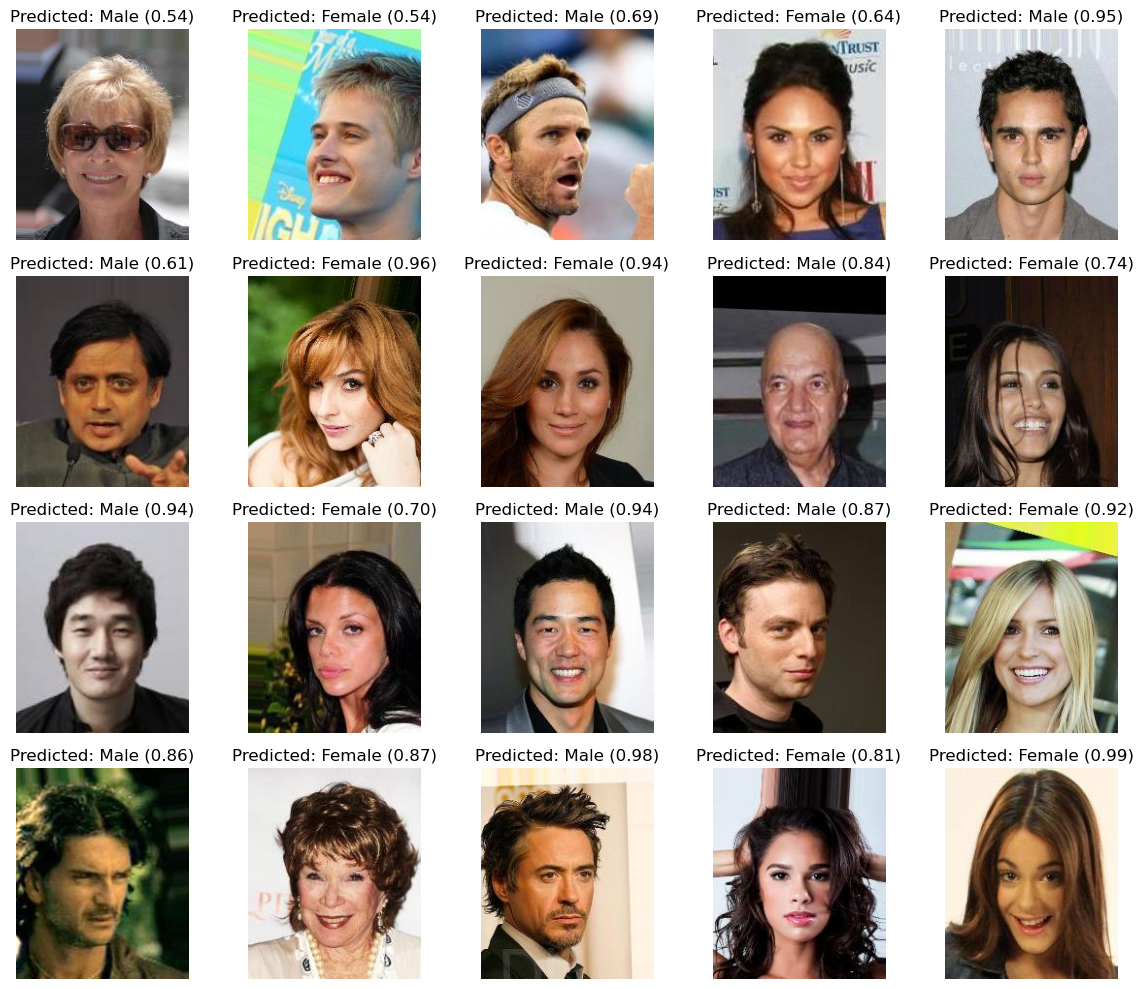

In [60]:
# Select 20 sample indices from the test set
sample_indices = np.random.choice(len(test_generator), size=20, replace=False)

# Use predict_generator to get predicted probabilities
test_predictions = best_resnet_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels based on a threshold
threshold = 0.5
binary_predictions = (test_predictions > threshold).astype(int)

# Display sample images in a 5x4 grid
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

for i, ax in enumerate(axes.flatten()):
    if i < len(sample_indices):
        index = sample_indices[i]
        image_path = test_generator.filepaths[index]
        image = Image.open(image_path)
        predicted_probability = test_predictions[index][0]
        predicted_label = binary_predictions[index][0]
        
        ax.imshow(image)
        ax.set_title(f'Predicted: Male ({predicted_probability:.2f})' if predicted_label == 1 else f'Predicted: Female ({1-predicted_probability:.2f})')
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

I can see for images that are predicted wrong by the model have very low probabilities. Because my threshold is 0.5, and probabilities greater than 0.5 are predicted male. However the wrong predictions have probabilities indicating male as 0.54 or indicating female as 0.54 which are very close to be flipped in prediction. 

# Result, Analysis and Discussion 

In [55]:
data = {'Validation Accuracy': valid_accuracy_list, 'Validation Loss': valid_loss_list, 'Test Accuracy':test_accuracy_list, 'Test Loss:': test_loss_list}
result_df = pd.DataFrame(data)
result_df.index = ['Simple CNN', 'Simple Resnet']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


Validation Accuracy  Validation Loss  Test Accuracy  Test Loss:
Simple CNN                0.977802         0.060517       0.970394    0.085205
Simple Resnet             0.916042         0.386419       0.898106    0.325826

The table shows that a simple CNN model can work extremely well on our problem and datasets. It works even better than a complexed architecture like ResNet that is classified as the one for image classification. The simple CNN model is able to achieve 97% accuracy while the simple ResNet model is only able to achieve 89.8% accuracy.  
Furthermore on looking at our models predicted samples, I can see that even a very good prediction model like my simple CNN model still has problems identifying true gender for faces of young kids or people with skin colors. That really raise some ethical questions but it could be due to the dataset structure itself. A better dataset with various of images with skin colors, ages will certainly be applied to find out. This can be a further study for anyone who is interested in gender bias in deep modeling or machine learning. 

## Sources
- Deep Residual Learning for Image Recognition by Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, submitted on 10 Dec 2015. https://arxiv.org/abs/1512.03385
- Data augmentation https://www.tensorflow.org/tutorials/images/data_augmentation
- Python Machine Learning and Deep Learning with Tensorflow 2 by Sebastian Raschka & Vahid Mirjalili: Chapter 15 - Classifying Images with Deep Convolutional Nerural Networks.